In [15]:
"""# Importing Libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from scipy.ndimage import zoom
from skimage.measure import block_reduce
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers.core import Reshape
from keras.layers import LSTM
from keras import regularizers

tf.compat.v1.enable_eager_execution()

In [2]:
"""# Loading Data"""

path = "../../Cog_DataSets/testing/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/testing/"
test_acc = np.load(path+"testAccelerometer.npy")
test_grav = np.load(path+"testGravity.npy")
test_gyro = np.load(path+"testGyroscope.npy")
test_jinsAcc = np.load(path+"testJinsAccelerometer.npy")
test_jinsGyro = np.load(path+"testJinsGyroscope.npy")
test_Label =np.load(path+"testLabels.npy") 
test_linAcc = np.load(path+"testLinearAcceleration.npy")
test_MsAcc = np.load(path+"testMSAccelerometer.npy")
test_MsGyro = np.load(path + "testMSGyroscope.npy")
test_MsMag = np.load(path+"testMagnetometer.npy")
# test_acc

path = "../../Cog_DataSets/training/"
# path = "drive/MyDrive/Colab Notebooks/CogAge/Datasets/training/"
train_acc = np.load(path+"trainAccelerometer.npy")
train_grav = np.load(path+"trainGravity.npy")
train_gyro = np.load(path+"trainGyroscope.npy")
train_jinsAcc = np.load(path+"trainJinsAccelerometer.npy")
train_jinsGyro = np.load(path+"trainJinsGyroscope.npy")
train_Label =np.load(path+"trainLabels.npy") 
train_linAcc = np.load(path+"trainLinearAcceleration.npy")
train_MsAcc = np.load(path+"trainMSAccelerometer.npy")
train_MsGyro = np.load(path + "trainMSGyroscope.npy")
train_MsMag = np.load(path+"trainMagnetometer.npy")
# print(train_Label.shape)

In [3]:
"""# Reshape and stack Data Before Fitting to Model"""
# changing shape of sensor data to (#,400,3)
# downsample
train_acc_reshaped = block_reduce(train_acc, block_size=(1, 2, 1), func=np.mean)
train_gyro_reshaped = block_reduce(train_gyro, block_size=(1, 2, 1), func=np.mean)
train_grav_reshaped = block_reduce(train_grav, block_size=(1, 2, 1), func=np.mean)
train_linAcc_reshaped = block_reduce(train_linAcc, block_size=(1, 2, 1), func=np.mean)
# upsample
train_MsAcc_reshaped = resize(train_MsAcc, (2284, 400, 3), mode='edge')
train_MsGyro_reshaped = resize(train_MsGyro, (2284, 400, 3), mode='edge')
# upsample
train_MsMag_reshaped = np.repeat(train_MsMag, 2, axis=1)
train_jinsAcc_reshaped = np.repeat(train_jinsAcc, 5, axis=1)
train_jinsGyro_reshaped = np.repeat(train_jinsGyro, 5, axis=1)

test_acc_reshaped = block_reduce(test_acc, block_size=(1, 2, 1), func=np.mean)
test_gyro_reshaped = block_reduce(test_gyro, block_size=(1, 2, 1), func=np.mean)
test_grav_reshaped = block_reduce(test_grav, block_size=(1, 2, 1), func=np.mean)
test_linAcc_reshaped = block_reduce(test_linAcc, block_size=(1, 2, 1), func=np.mean)
test_MsAcc_reshaped = resize(test_MsAcc, (2288, 400, 3), mode='edge')
test_MsGyro_reshaped = resize(test_MsGyro, (2288, 400, 3), mode='edge')
test_MsMag_reshaped = np.repeat(test_MsMag, 2, axis=1)
test_jinsAcc_reshaped = np.repeat(test_jinsAcc, 5, axis=1)
test_jinsGyro_reshaped = np.repeat(test_jinsGyro, 5, axis=1)

# all data of shape #,400,3
# adding all relative data.
# Mobile training accelerometer + Mobile testing accelerometer data
train_acc_reshaped = np.append(train_acc_reshaped,test_acc_reshaped, axis=0)
train_gyro_reshaped = np.append(train_gyro_reshaped,test_gyro_reshaped, axis=0)
train_grav_reshaped = np.append(train_grav_reshaped,test_grav_reshaped, axis=0)
train_linAcc_reshaped = np.append(train_linAcc_reshaped,test_linAcc_reshaped, axis=0)
train_MsAcc_reshaped = np.append(train_MsAcc_reshaped,test_MsAcc_reshaped, axis=0)
train_MsGyro_reshaped = np.append(train_MsGyro_reshaped,test_MsGyro_reshaped, axis=0)
train_MsMag_reshaped = np.append(train_MsMag_reshaped,test_MsMag_reshaped, axis=0)
train_jinsAcc_reshaped = np.append(train_jinsAcc_reshaped,test_jinsAcc_reshaped, axis=0)
train_jinsGyro_reshaped = np.append(train_jinsGyro_reshaped,test_jinsGyro_reshaped, axis=0)


print("Shape of all sensors after up/down sample... ", train_acc_reshaped.shape, train_gyro_reshaped.shape, train_grav_reshaped.shape, train_linAcc_reshaped.shape
                       , train_MsAcc_reshaped.shape, train_MsGyro_reshaped.shape, train_MsMag_reshaped.shape,
                       train_jinsAcc_reshaped.shape, train_jinsGyro_reshaped.shape)

# all data of shape 4572,400,3
# 4572 = 2284(training) + 2288(testing)


# stack
all_data = np.stack([train_acc_reshaped, train_gyro_reshaped, train_grav_reshaped, train_linAcc_reshaped
                       , train_MsAcc_reshaped, train_MsGyro_reshaped, train_MsMag_reshaped,
                       train_jinsAcc_reshaped, train_jinsGyro_reshaped], axis=-1)

all_Label = np.append(train_Label, test_Label, axis=-1)


Shape of all sensors after up/down sample...  (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3) (4572, 400, 3)


In [4]:
# 70% training data + labels
train_data = all_data[: int(all_data.shape[0]*0.7)]
# 30% testing data + labels
test_data = all_data[int(all_data.shape[0]*0.7):]
train_labels = all_Label[: int(all_Label.shape[0]*0.7)]
test_labels = all_Label[int(all_Label.shape[0]*0.7):]

print("\nShape of training and testin data + labels...\n")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)


# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print("Shape of training + validation Data")
print(np.shape(x_train), np.shape(y_train))

y_train = to_categorical(y_train, num_classes=55)
y_val = to_categorical(y_val, num_classes=55)

print("Shape of training + validation Labels")
print(np.shape(y_train), np.shape(y_val))



Shape of training and testin data + labels...

(3200, 400, 3, 9) (1372, 400, 3, 9)
(3200,) (1372,)
Shape of training + validation Data
(2560, 400, 3, 9) (2560,)
Shape of training + validation Labels
(2560, 55) (640, 55)


In [37]:
# HYPER PARAMTERS

# Filter parameters, i.e. about the number of inputs processed by each neuron of the convolutional layer
filter1Size = (11,1)
filter2Size = (13,1)
filter3Size = (13,1)

# Downsampling factors of the pooling layers
poolingLayer1Factor = (2,1)
poolingLayer2Factor = (3,1)
poolingLayer3Factor = (2,1)

# Number of feature maps processed by each convolutional layer
nbFeaturesLayer1 = 50
nbFeaturesLayer2 = 40
nbFeaturesLayer3 = 30

# Activation function of the convolutional layer(s)
activationConv = 'relu'

# Output dimension of the LSTM
outputLSTM = 100

# Parameters of the dense layer
activationMLP = 'relu'
inputMLP = 2000

# Training parameters
batchSize = 400
numberOfEpochs = 10
learningRate = 0.01

input_shape = (400,3,9)
nbClasses = 55
timeWindow = 400
nbSensors = 9

#-------------------------------------------------------------------------------------------------------
# normConv1Lstm: define a batch normalization + 2 convolutional/max-pooling + LSTM DNN
#-------------------------------------------------------------------------------------------------------
def normConv1Lstm(
    inputShape,
    nkerns,
    filterSizes,
    poolSizes,
    activationConv,
    timeWindow,
    nbSensors,
    outputLSTM,
    inputMLP,
    activationMLP,
    nbClasses,
    withSoftmax=True):

    outputSizeLastConv = int((timeWindow-filterSizes[0][0]+1)/poolSizes[0][0])
    #outputSizeLastConv = (timeWindow-filterSizes[0][0]+1)

    model = Sequential()

    # Batch normalization layer
    model.add(BatchNormalization(input_shape=inputShape))

    # Convolution + max-pooling layers
    model.add(Conv2D(nkerns[0], kernel_size=filterSizes[0], activation=activationConv))
    model.add(MaxPooling2D(pool_size=poolSizes[0]))

    # model.add(Conv2D(nkerns[0], kernel_size=filterSizes[0], activation='linear', input_shape=inputShape))
    # model.add(BatchNormalization())
    # model.add(Activation(activationConv))
    # model.add(MaxPooling2D(pool_size=poolSizes[0]))
    print(model.layers[-1].output_shape)
    # LSTM layer with a many-to-one implementation
    # Note: size of the output = (outputSizeLastConv, outputLSTM)
    model.add(Reshape((outputSizeLastConv,3*nkerns[0]))) 
    model.add(LSTM(outputLSTM,return_sequences=False))
    print('LSTM output size: ---------------------------')
    print(model.layers[-1].output_shape)

    # Fully-connected layer
    model.add(Dense(inputMLP, activation=activationMLP, kernel_regularizer=regularizers.L2(0.01)))
    print('Dense layer size: ---------------------------')
    print(model.layers[-1].output_shape)
    model.add(Dropout(0.5))

    # Softmax layer
    if withSoftmax:
        model.add(Dense(nbClasses, activation='softmax'))

    # Print the summary of the model
    model.summary

    # Return the model
    return model

model = normConv1Lstm(
    inputShape=(400,3,9),
    nkerns=[nbFeaturesLayer1, nbFeaturesLayer2, nbFeaturesLayer3],
    filterSizes=[filter1Size, filter2Size, filter3Size],
    poolSizes=[poolingLayer1Factor, poolingLayer2Factor, poolingLayer3Factor],
    activationConv='relu',
    timeWindow=400,
    nbSensors=9,
    outputLSTM=outputLSTM,
    inputMLP=inputMLP,
    activationMLP=activationMLP,
    nbClasses=55,
    withSoftmax=True)

(None, 195, 3, 50)
LSTM output size: ---------------------------
(None, 100)
Dense layer size: ---------------------------
(None, 2000)


2023-05-10 14:00:38.319602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 14:00:38.321624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 14:00:38.323238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [38]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learningRate),
    metrics=['accuracy']
)

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 400, 3, 9)        36        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 390, 3, 50)        5000      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 195, 3, 50)       0         
 2D)                                                             
                                                                 
 reshape_4 (Reshape)         (None, 195, 150)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               100400    
                                                                 
 dense_8 (Dense)             (None, 2000)             

In [44]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=numberOfEpochs,
    batch_size=batchSize
)

Epoch 1/10
7/7 [==============================] - 9s 1s/step - loss: 2.0908 - accuracy: 0.6223 - val_loss: 2.9385 - val_accuracy: 0.4141
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 2.2294 - accuracy: 0.5781 - val_loss: 2.5912 - val_accuracy: 0.5312
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 2.1335 - accuracy: 0.6195 - val_loss: 2.6255 - val_accuracy: 0.4797
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 2.0842 - accuracy: 0.6125 - val_loss: 2.5905 - val_accuracy: 0.4969
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 2.0948 - accuracy: 0.6098 - val_loss: 2.6341 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 2.0984 - accuracy: 0.6094 - val_loss: 2.6005 - val_accuracy: 0.4969
Epoch 7/10
7/7 [==============================] - 12s 2s/step - loss: 2.0285 - accuracy: 0.6258 - val_loss: 2.4875 - val_accuracy: 0.5250
Epoch 8/10
7/7 [=====================

KeyboardInterrupt: 

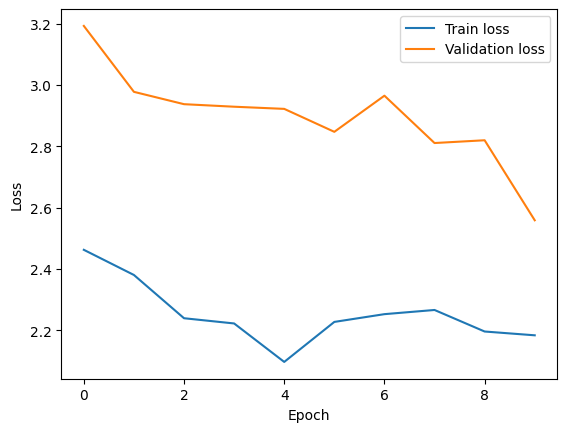

In [43]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the graph
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
estimatedLabels = np.argmax(model.predict(test_data),axis=-1)
estimatedLabels = estimatedLabels.flatten()

accuracy = accuracy_score(test_labels,estimatedLabels)
weightedF1 = f1_score(test_labels,estimatedLabels,average='weighted')
averageF1 = f1_score(test_labels,estimatedLabels,average='macro')
#confMat = confusion_matrix(testingLabels,estimatedLabels,labels=labelsTable.values())
allF1Scores = f1_score(test_labels,estimatedLabels,average=None)

# Print results
print('   Test accuracy = %.2f %%' % (accuracy*100))
print('   Weighted F1-score = %.4f' % (weightedF1))
print('   Average F1-score = %.4f' % (averageF1))
# print('   All F1-scores:')
# print(allF1Scores)
print('-------------------------------------------------------')

2023-05-10 13:50:16.610064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 13:50:16.611906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 13:50:16.613436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - 3s 51ms/step
   Test accuracy = 63.05 %
   Weighted F1-score = 0.6264
   Average F1-score = 0.6234
-------------------------------------------------------
